In [1]:
import os
import time
import pandas as pd
import numpy as np
from geojson import dump
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import networkx as nx
import os
import osmnx as ox
import pickle
import struct
import csv

def loadQUANTMatrix(filename):
    with open(filename,'rb') as f:
        (m,) = struct.unpack('i', f.read(4))
        (n,) = struct.unpack('i', f.read(4))
        print("loadQUANTMatrix::m=",m,"n=",n)
        matrix = np.arange(m*n,dtype=np.float64).reshape(m, n) #and hopefully m===n, but I'm not relying on it
        for i in range(0,m):
            data = struct.unpack('{0}f'.format(n), f.read(4*n)) #read a row back from the stream - data=list of floats
            for j in range(0,n):
                matrix[i,j] = data[j]
    return matrix

def saveMatrix(matrix,filename):
    with open(filename,'wb') as f:
        pickle.dump(matrix,f)

class QUANTLHModel:
    """
    constructor
    @param n number of residential zones (MSOA)
    @param m number of school point zones
    """

    def __init__(self, m, n):
        # constructor
        self.m = m
        self.n = n
        self.Ei = np.zeros(m)
        self.Aj = np.zeros(n)
        self.cij_0 = np.zeros(1)  # costs matrix - set to something BIG later
        self.cij_1 = np.zeros(1)  # costs matrix - set to something BIG later
        self.cij_2 = np.zeros(1)  # costs matrix - set to something BIG later
        self.SObs_0 = np.zeros(1)
        self.SObs_1 = np.zeros(1)
        self.SObs_2 = np.zeros(1)

    ################################################################################

    """
    setPopulationVectorEi
    Overload of setPopulationEi to set Ei directly from a vector, rather than a Pandas dataframe.
    """
    def setPopulationVectorEi(self, Ei):
        self.Ei = Ei
        assert len(self.Ei) == self.m, "FATAL: setPopulationEi length Ei=" + str(
            len(self.Ei)) + " MUST equal model definition size of m=" + str(self.m)

    ################################################################################

    """
    setPopulationEi
    Given a data frame containing one column with the zone number (i) and one column
    with the actual data values, fill the Ei population property with data so that
    the position in the Ei numpy array is the zonei field of the data.
    The code is almost identical to the setAttractorsAj method.
    NOTE: max(i) < self.m
    """
    def setPopulationEi(self, df, zoneiColName, dataColName):
        df2 = df.sort_values(by=[zoneiColName])
        self.Ei = df2[dataColName].to_numpy()
        assert len(self.Ei) == self.m, "FATAL: setPopulationEi length Ei=" + str(len(self.Ei)) + " MUST equal model definition size of m=" + str(self.m)

    ################################################################################

    """
    setAttractorsAj
    Given a data frame containing one column with the zone number (j) and one column
    with the actual data values, fill the Aj attractors property with data so that
    the position in the Aj numpy array is the zonej field of the data.
    The code is almost identical to the setPopulationEi method.
    NOTE: max(j) < self.n
    """
    def setAttractorsAj(self, df, zonejColName, dataColName):
        df2 = df.sort_values(by=[zonejColName])
        self.Aj = df2[dataColName].to_numpy()
        assert len(self.Aj) == self.n, "FATAL: setAttractorsAj length Aj=" + str(len(self.Aj)) + " MUST equal model definition size of n=" + str(self.n)

    ################################################################################

    """
    setCostsMatrix
    Assign the cost matrix for the model to use when it runs.
    NOTE: this MUST match the m x n order of the model and be a numpy array
    """
    def setCostMatrixCij(self, cij_0, cij_1, cij_2):
        i, j = cij_0.shape  # Hopefully cij_0.shape = cij_1.shape = cij_2.shape
        assert i == self.m, "FATAL: setCostsMatrix cij matrix is the wrong size, cij.m=" + str(i) + " MUST match model definition of m=" + str(self.m)
        assert j == self.n, "FATAL: setCostsMatrix cij matrix is the wrong size, cij.n=" + str(j) + " MUST match model definition of n=" + str(self.n)
        self.cij_0 = cij_0
        self.cij_1 = cij_1
        self.cij_2 = cij_2

    ################################################################################

    """
    setObsMatrix
    Assign the cost matrix for the model to use when it runs.
    NOTE: this MUST match the m x n order of the model and be a numpy array
    """
    def setObsMatrix(self, SObs_0, SObs_1, SObs_2):
        i, j = SObs_0.shape  # Hopefully cij_0.shape = SObs_0.shape = SObs_0.shape
        assert i == self.m, "FATAL: setCostsMatrix cij matrix is the wrong size, cij.m=" + str(
            i) + " MUST match model definition of m=" + str(self.m)
        assert j == self.n, "FATAL: setCostsMatrix cij matrix is the wrong size, cij.n=" + str(
            j) + " MUST match model definition of n=" + str(self.n)
        self.SObs_0 = SObs_0
        self.SObs_1 = SObs_1
        self.SObs_2 = SObs_2

    ################################################################################

    """
    computeCBar
    Compute average trip length TODO: VERY COMPUTATIONALLY INTENSIVE - FIX IT
    @param Sij trips matrix containing the flow numbers between MSOA (i) and schools (j)
    @param cij trip times between i and j
    """
    def computeCBar(self, Sij, cij):
        CNumerator = np.sum(Sij * cij)
        CDenominator = np.sum(Sij)
        cbar = CNumerator / CDenominator
        return cbar

    ################################################################################

    """
        Calculate Dj for a trips matrix.
        Two methods are presented here, one which is simple and very slow and one
        which uses python vector maths and is much faster. Once 2 is proven equal
        to 1, then it can be used exclusively. This function is mainly used for
        testing with the TensorFlow and other implementations.
        """

    def calculateDj(self, Tij):
        (M, N) = np.shape(Tij)
        Dj = np.zeros(N)
        Dj = Tij.sum(axis=0)
        return Dj

    ###############################################################################

    """
    run Model run3modes
    Quant model for three modes of transport
    @returns Sij predicted flows between i and j
    """
    def run3modes(self):
        # run model
        # i = employment zone
        # j = residential zone
        # Ei = number of jobs at MSOA location
        # Aj = attractor of HH (number of dwellings)
        # cij_mode = travel cost for "mode" (i.e. road, bus, rail)
        # Modes: Road = 0, Bus = 1, Rail = 2
        # Beta = Beta values for three modes - this is also output
        # QUANT data:
        # Observed trips data: "SObs_1.bin", "SObs_2.bin", "SObs_3.bin"
        # Travel cost per mode: "dis_roads_min.bin", "dis_bus_min.bin", "dis_gbrail_min.bin"
        # Note the use of 1,2,3 for modes in the files different from 0,1,2 in the code.
        # Returns predicted flows per mode: "SPred_1.bin", "SPred_2.bin", "SPred_3.bin"

        # Initialisation of parameters
        converged = False  # initialise convergence check param
        n_modes = 3  # Number of modes
        cij_k = [self.cij_0, self.cij_1, self.cij_2]  # list of cost matrices
        SObs_k = [self.SObs_0, self.SObs_1, self.SObs_2]  # list of obs trips matrices

        # Set up Beta for modes 0, 1 and 2 to 1.0
        Beta = np.ones(n_modes)

        # Compute sum of origins and destinations

        '''
        # OiObs : vector with dimension = number of oringins
        OiObs = np.zeros(self.n)
        for k in range(n_modes):
            OiObs += SObs_k[k].sum(axis=1)
        '''

        # DjObs : vector with dimension = number of destinations
        DjObs = [[] for i in range(n_modes)]
        for k in range(n_modes):
            DjObs[k] = np.zeros(self.n)
        for k in range(n_modes):
            DjObs[k] += SObs_k[k].sum(axis=1)

        DjPred = [[] for i in range(n_modes)]
        DjPredSum = np.zeros(n_modes)
        DjObsSum = np.zeros(n_modes)
        delta = np.zeros(n_modes)


        # Convergence loop:
        print("Calibrating the model...")
        iteration = 0
        while converged != True:
            iteration += 1
            print("Iteration: ", iteration)

            # Initialise variables:
            Sij = [[] for i in range(n_modes)]  # initialise Sij with a number of empty lists equal to n_modes

            # hold copy of pre multiplied copies of -Beta_k * cij[k] for each mode
            ExpMBetaCijk = [[] for k in range(n_modes)]
            for kk in range(n_modes):
                ExpMBetaCijk[kk] = np.exp(-Beta[kk] * cij_k[kk])

            for k in range(n_modes):  # mode loop
                Sij[k] = np.zeros(self.m * self.n).reshape(self.m, self.n)
                for i in range(self.m):
                    denom = 0
                    for kk in range(n_modes):
                        denom += np.sum(self.Aj * ExpMBetaCijk[kk][i, :])
                    Sij2 = self.Ei[i] * (self.Aj * ExpMBetaCijk[k][i, :] / denom)
                    Sij[k][i, :] = Sij2  # put answer slice back in return array

            # Calibration with CBar values
            # Calculate mean predicted trips and mean observed trips (this is CBar)
            CBarPred = np.zeros(n_modes)
            CBarObs = np.zeros(n_modes)
            delta = np.ones(n_modes)
            for k in range(n_modes):
                CBarPred[k] = self.computeCBar(Sij[k], cij_k[k])
                CBarObs[k] = self.computeCBar(SObs_k[k], cij_k[k])
                delta[k] = np.absolute(CBarPred[k] - CBarObs[k])  # the aim is to minimise delta[0]+delta[1]+...
            # delta check on all betas (Beta0, Beta1, Beta2) stopping condition for convergence
            # double gradient descent search on Beta0 and Beta1 and Beta2
            converged = True
            for k in range(n_modes):
                if (delta[k] / CBarObs[k] > 0.001):
                    Beta[k] = Beta[k] * CBarPred[k] / CBarObs[k]
                    converged = False
            '''
            # Calibration with Observed flows
            for k in range(n_modes):
                DjPred[k] = self.calculateDj(Sij[k])
                DjPredSum[k] = np.sum(DjPred[k])
                DjObsSum[k] = np.sum(DjObs[k])
                delta[k] = DjPredSum[k] - DjObsSum[k]
            # delta check on beta stopping condition for convergence
            # gradient descent search on beta
            converged = True
            for k in range(n_modes):
                if (delta[k] / DjObsSum[k] > 0.001):
                    Beta[k] = Beta[k] * DjPredSum[k] / DjObsSum[k]
                    converged = False
            '''
            CBarPred = np.zeros(n_modes)
            # Calculate CBar
            for k in range(n_modes):
                CBarPred[k] = self.computeCBar(Sij[k], cij_k[k])

            # Debug:
            # commuter sum blocks
            TotalSij_roads = Sij[0].sum()
            TotalSij_bus = Sij[1].sum()
            TotalSij_rail = Sij[2].sum()
            TotalEi = self.Ei.sum()  # total jobs = pu+pr above
            # print("i= {0:d} beta_roads={1:.6f} beta_bus={2:.6f} beta_rail={3:.6f} cbar_pred_roads={4:.1f} cbar_pred_busr={5:.1f} cbar_pred_rail={6:.1f}"
            #         .format(iteration, Beta[0], Beta[1], Beta[2], CBarPred[0], CBarPred[1], CBarPred[2]))
            # print("TotalSij_roads={0:.1f} TotalSij_bus={1:.1f} TotalSij_rail={2:.1f} Total={3:.1f} ({4:.1f})"
            #       .format(TotalSij_roads, TotalSij_bus, TotalSij_rail, TotalSij_roads + TotalSij_bus + TotalSij_rail, TotalEi))

        return Sij, Beta, CBarPred  # Note that Sij = [Sij_k=0 , Sij_k=1, Sij_k=2] and CBarPred = [CBarPred_0, CBarPred_1, CBarPred_2]

    ################################################################################

    """
    run Model run3modes_NoCalibration
    Quant model for three modes of transport without calibration
    @returns Sij predicted flows between i and j
    """
    def run3modes_NoCalibration(self, Beta):
        n_modes = len(Beta)  # Number of modes
        print("Running model for ", n_modes, " modes.")

        # Initialise variables:
        Sij = [[] for i in range(n_modes)]  # initialise Sij with a number of empty lists equal to n_modes
        cij_k = [self.cij_0, self.cij_1, self.cij_2]  # list of cost matrices

        # hold copy of pre multiplied copies of -Beta_k * cij[k] for each mode
        ExpMBetaCijk = [[] for k in range(n_modes)]
        for kk in range(n_modes):
            ExpMBetaCijk[kk] = np.exp(-Beta[kk] * cij_k[kk])

        for k in range(n_modes):  # mode loop
            Sij[k] = np.zeros(self.m * self.n).reshape(self.m, self.n)
            for i in range(self.m):
                denom = 0
                for kk in range(n_modes):
                    denom += np.sum(self.Aj * ExpMBetaCijk[kk][i, :])
                Sij2 = self.Ei[i] * (self.Aj * ExpMBetaCijk[k][i, :] / denom)
                Sij[k][i, :] = Sij2  # put answer slice back in return array

        CBarPred = np.zeros(n_modes)  # initialise CBarPred
        for k in range(n_modes):
            CBarPred[k] = self.computeCBar(Sij[k], cij_k[k])

        return Sij, CBarPred

    ################################################################################

    """
    computeProbabilities3modes
    Compute the probability of a flow from an MSOA zone to any (i.e. all) of the possible point zones
    """
    def computeProbabilities3modes(self, Sij):
        print("Computing probabilities")
        n_modes = 3
        probSij = [[] for i in range(n_modes)]  # initialise Sij with a number of empty list equal to n_modes

        for k in range(n_modes):
            probSij[k] = np.arange(self.m * self.n, dtype=np.float64).reshape(self.m, self.n)
            for i in range(self.m):
                sum = np.sum(Sij[k][i,])
                if sum <= 0:
                    sum = 1  # catch for divide by zero - just let the zero probs come through to the final matrix
                probSij[k][i,] = Sij[k][i,] / sum

        return probSij
    
class QUANTRetailModel(QUANTLHModel):
    """
    constructor
    @param n number of residential zones
    @param m number of retail zones
    """
    def __init__(self,m,n):
        #constructor
        super().__init__(m,n)

    ################################################################################

    """
    loadGeolytixData
    @param filename Name of file to load - this is the Geolytix restricted access data with
    the floorspace and retail data
    @returns DataFrame containing [key,zonei,east,north] and [zonei,Modelled turnover annual]
    """
    @staticmethod
    def loadGeolytixData(filename):
        missing_values = ['-', 'n/a', 'na', '--', ' -   ']
        df = pd.read_csv(filename,usecols=['id','fascia','modelled sq ft','Modelled turnover annual','bng_e','bng_n'], na_values=missing_values)
        df.dropna(axis=0,inplace=True)
        df.reset_index(drop=True,inplace=True) # IMPORTANT, otherwise indexes remain for ALL the rows i.e. idx=0..OriginalN NOT true row count!
        dfzones = pd.DataFrame({'id':df.id,'zonei':df.index,'east':df.bng_e,'north':df.bng_n})
        dfattractors = pd.DataFrame({'zonei':df.index,'Modelled turnover annual':df['Modelled turnover annual']}) # could also used floorspace
        return dfzones, dfattractors
    
def costMSOAToPoint_3modes(cij_roads, cij_bus, cij_rail, dfPoints, OXF_MSOA_list):
    # const to define what speed we travel the additional distance to the retail point e.g. 30mph = 13 ms-1
    metresPerSec_roads = 13.0 # 30 miles/h = 47 km/h
    metresPerSec_bus = 13.0  # 30 miles/h = 47 km/h
    metresPerSec_rail = 13.0  # 30 miles/h = 47 km/h

    # read in the road, bus and rail centroids for the cij matrix
    df_roads = pd.read_csv(os.path.join('data', 'roadcentroidlookup_QC.csv'), index_col='zonecode')
    df_bus = pd.read_csv(os.path.join('data', 'buscentroidlookup_QC.csv'), index_col='zonecode')
    df_rail = pd.read_csv(os.path.join('data', 'gbrailcentroidlookup_QC.csv'), index_col='zonecode')

    # Filter out Oxfordshire from EWS files
    df_roads = df_roads.loc[OXF_MSOA_list]  # Filter rows
    df_bus = df_bus.loc[OXF_MSOA_list]  # Filter rows
    df_rail = df_rail.loc[OXF_MSOA_list]  # Filter rows

    df_roads['zonecode'] = df_roads.index  # turn the index (i.e. MSOA codes) back into a columm
    df_bus['zonecode'] = df_bus.index  # turn the index (i.e. MSOA codes) back into a columm
    df_rail['zonecode'] = df_rail.index  # turn the index (i.e. MSOA codes) back into a columm

    # Reset indexes
    df_roads.reset_index(drop=True, inplace=True)
    df_bus.reset_index(drop=True, inplace=True)
    df_rail.reset_index(drop=True, inplace=True)

    # Overwrite the zonei column with the new index
    df_roads['zonei'] = df_roads.index
    df_bus['zonei'] = df_bus.index
    df_rail['zonei'] = df_rail.index

    # code this into a geodataframe so we can make a spatial index
    gdf_roads = gpd.GeoDataFrame(df_roads, crs='epsg:4326', geometry=gpd.points_from_xy(df_roads.vertex_lon, df_roads.vertex_lat))
    gdf_bus = gpd.GeoDataFrame(df_bus, crs='epsg:4326', geometry=gpd.points_from_xy(df_bus.vertex_lon, df_bus.vertex_lat))
    gdf_rail = gpd.GeoDataFrame(df_rail, crs='epsg:4326', geometry=gpd.points_from_xy(df_rail.vertex_lon, df_rail.vertex_lat))

    # but it's lat/lon and we want east/north, convert crs:
    centroids_roads = gdf_roads.to_crs("EPSG:27700")
    centroids_bus = gdf_bus.to_crs("EPSG:27700")
    centroids_rail = gdf_rail.to_crs("EPSG:27700")

    dest_unary_roads = centroids_roads["geometry"].unary_union  # and need this join for the centroid points nearest lookup
    dest_unary_bus = centroids_bus["geometry"].unary_union  # and need this join for the centroid points nearest lookup
    dest_unary_rail = centroids_rail["geometry"].unary_union  # and need this join for the centroid points nearest lookup

    # create a new MSOA to points cost matix
    m, n = cij_roads.shape
    p, cols = dfPoints.shape
    # print("array size = ", p, m)

    cijpoint_roads = np.zeros(m * p, dtype=np.float64).reshape(m, p)  # so m=MSOA and p=points index
    cijpoint_bus = np.zeros(m * p, dtype=np.float64).reshape(m, p)  # so m=MSOA and p=points index
    cijpoint_rail = np.zeros(m * p, dtype=np.float64).reshape(m, p)  # so m=MSOA and p=points index

    # now make the amended cost function
    count = 0
    for row in dfPoints.itertuples(index=False):  # NOTE: iterating over Pandas rows is supposed to be bad - how else to do this?
        if (count % 50 == 0): print("costs::costMSOAToPoint ", count, "/", p)
        count += 1

        p_zonei = getattr(row, 'zonei')
        p_east = getattr(row, 'east')
        p_north = getattr(row, 'north')

        near_roads = nearest_points(Point(p_east, p_north), dest_unary_roads)
        near_bus = nearest_points(Point(p_east, p_north), dest_unary_bus)
        near_rail = nearest_points(Point(p_east, p_north), dest_unary_rail)

        match_geom_roads = centroids_roads.loc[centroids_roads.geometry == near_roads[1]]
        match_geom_bus = centroids_bus.loc[centroids_bus.geometry == near_bus[1]]
        match_geom_rail = centroids_rail.loc[centroids_rail.geometry == near_rail[1]]

        pmsoa_zonei_roads = int(match_geom_roads.zonei.iloc[0])  # closest point msoa zone
        pmsoa_zonei_bus = int(match_geom_bus.zonei.iloc[0])  # closest point msoa zone
        pmsoa_zonei_rail = int(match_geom_rail.zonei.iloc[0])  # closest point msoa zone

        pmsoa_pt_roads = match_geom_roads.geometry
        pmsoa_pt_bus = match_geom_bus.geometry
        pmsoa_pt_rail = match_geom_rail.geometry

        pmsoa_east_roads = float(pmsoa_pt_roads.centroid.x.iloc[0])
        pmsoa_east_bus = float(pmsoa_pt_bus.centroid.x.iloc[0])
        pmsoa_east_rail = float(pmsoa_pt_rail.centroid.x.iloc[0])

        pmsoa_north_roads = float(pmsoa_pt_roads.centroid.y.iloc[0])
        pmsoa_north_bus = float(pmsoa_pt_bus.centroid.y.iloc[0])
        pmsoa_north_rail = float(pmsoa_pt_rail.centroid.y.iloc[0])

        dx_roads = p_east - pmsoa_east_roads
        dx_bus = p_east - pmsoa_east_bus
        dx_rail = p_east - pmsoa_east_rail

        dy_roads = p_north - pmsoa_north_roads
        dy_bus = p_north - pmsoa_north_bus
        dy_rail = p_north - pmsoa_north_rail

        dist_roads = np.sqrt(dx_roads * dx_roads + dy_roads * dy_roads)  # dist between point and centroid used for shortest path
        dist_bus = np.sqrt(dx_bus * dx_bus + dy_bus * dy_bus)  # dist between point and centroid used for shortest path
        dist_rail = np.sqrt(dx_rail * dx_rail + dy_rail * dy_rail)  # dist between point and centroid used for shortest path

        # work out an additional delta cost based on increased time getting from this point to the centroid
        deltaCost_roads = (dist_roads / metresPerSec_roads) / 60.0  # transit time in mins
        deltaCost_bus = (dist_bus / metresPerSec_bus) / 60.0  # transit time in mins
        deltaCost_rail = (dist_rail / metresPerSec_rail) / 60.0  # transit time in mins

        # now write every cij value for msoa_zonei to p_zonei (closest) PLUS deltaCose for p_zonei to actual point
        for i in range(n):
            C1_roads = cij_roads[pmsoa_zonei_roads, i]  # yes, this is right for a trip from MSOA to closest point MSOA - QUANT is BACKWARDS
            C1_bus = cij_bus[pmsoa_zonei_bus, i]  # yes, this is right for a trip from MSOA to closest point MSOA - QUANT is BACKWARDS
            C1_rail = cij_rail[pmsoa_zonei_rail, i]  # yes, this is right for a trip from MSOA to closest point MSOA - QUANT is BACKWARDS

            cijpoint_roads[i, p_zonei] = C1_roads + deltaCost_roads
            cijpoint_bus[i, p_zonei] = C1_bus + deltaCost_bus
            cijpoint_rail[i, p_zonei] = C1_rail + deltaCost_rail

            # NOTE: you can only go in one direction with a matrix that is asymmetric

    return cijpoint_roads, cijpoint_bus, cijpoint_rail

def run3modes_NoCalibration(self, Beta):
        n_modes = len(Beta)  # Number of modes
        print("Running model for ", n_modes, " modes.")

        # Initialise variables:
        Sij = [[] for i in range(n_modes)]  # initialise Sij with a number of empty lists equal to n_modes
        cij_k = [self.cij_0, self.cij_1, self.cij_2]  # list of cost matrices

        # hold copy of pre multiplied copies of -Beta_k * cij[k] for each mode
        ExpMBetaCijk = [[] for k in range(n_modes)]
        for kk in range(n_modes):
            ExpMBetaCijk[kk] = np.exp(-Beta[kk] * cij_k[kk])

        for k in range(n_modes):  # mode loop
            Sij[k] = np.zeros(self.m * self.n).reshape(self.m, self.n)
            for i in range(self.m):
                denom = 0
                for kk in range(n_modes):
                    denom += np.sum(self.Aj * ExpMBetaCijk[kk][i, :])
                Sij2 = self.Ei[i] * (self.Aj * ExpMBetaCijk[k][i, :] / denom)
                Sij[k][i, :] = Sij2  # put answer slice back in return array

        CBarPred = np.zeros(n_modes)  # initialise CBarPred
        for k in range(n_modes):
            CBarPred[k] = self.computeCBar(Sij[k], cij_k[k])

        return Sij, CBarPred

OXF_MSOA_df =  pd.read_excel('data/msoa_data.xlsx', usecols=["msoa11cd"]) # import file with OXF MSOA codes
OXF_MSOA_df.columns = ['areakey'] # rename column "msoa11cd" to "areakey"
OXF_MSOA_list = OXF_MSOA_df['areakey'].tolist()
del OXF_MSOA_list[-1]

zonecodes_EWS = pd.read_csv('data/EWS_ZoneCodes.csv')
zonecodes_EWS.set_index('areakey')
zonecodes_EWS_list = zonecodes_EWS['areakey'].tolist()

cij_road_EWS = loadQUANTMatrix('data/dis_roads_min.bin')
cij_road_EWS_df = pd.DataFrame(cij_road_EWS, index=zonecodes_EWS_list, columns=zonecodes_EWS_list)
cij_road_OXF_df = cij_road_EWS_df[OXF_MSOA_list]
cij_road_OXF_df = cij_road_OXF_df.loc[OXF_MSOA_list]
cij_road_OXF = cij_road_OXF_df.to_numpy()
cij_road_OXF[cij_road_OXF < 1] = 1 

cij_bus_EWS = loadQUANTMatrix('data/dis_bus_min.bin')
cij_bus_EWS_df = pd.DataFrame(cij_bus_EWS, index=zonecodes_EWS_list, columns=zonecodes_EWS_list) # turn the numpy array into a pd dataframe, (index and columns: MSOA codes)
cij_bus_OXF_df = cij_bus_EWS_df[OXF_MSOA_list]  # Create OXF df filtering EWS columns
cij_bus_OXF_df = cij_bus_OXF_df.loc[OXF_MSOA_list]  # Filter rows
cij_bus_OXF = cij_bus_OXF_df.to_numpy()  # numpy matrix for OXF (same format as utils loadQUANTMatrix)
cij_bus_OXF[cij_bus_OXF < 1] = 1  # lower limit of 1 minute links

cij_rail_EWS = loadQUANTMatrix('data/dis_gbrail_min.bin')
cij_rail_EWS_df = pd.DataFrame(cij_rail_EWS, index=zonecodes_EWS_list, columns=zonecodes_EWS_list) # turn the numpy array into a pd dataframe, (index and columns: MSOA codes)
cij_rail_OXF_df = cij_rail_EWS_df[OXF_MSOA_list]  # Create OXF df filtering EWS columns
cij_rail_OXF_df = cij_rail_OXF_df.loc[OXF_MSOA_list]  # Filter rows
cij_rail_OXF = cij_rail_OXF_df.to_numpy()  # numpy matrix for OXF (same format as utils loadQUANTMatrix)
cij_rail_OXF[cij_rail_OXF < 1] = 1  # lower limit of 1 minute links

SObs_road_EWS = loadQUANTMatrix('data/SObs_1.bin')
SObs_road_EWS_df = pd.DataFrame(SObs_road_EWS, index=zonecodes_EWS_list, columns=zonecodes_EWS_list) # turn the numpy array into a pd dataframe, (index and columns: MSOA codes)
SObs_road_OXF_df = SObs_road_EWS_df[OXF_MSOA_list]  # Create OXF df filtering EWS columns
SObs_road_OXF_df = SObs_road_OXF_df.loc[OXF_MSOA_list]  # Filter rows
SObs_road_OXF = SObs_road_OXF_df.to_numpy()  # numpy matrix for OXF (same format as utils loadQUANTMatrix)

SObs_bus_EWS = loadQUANTMatrix('data/SObs_2.bin')
SObs_bus_EWS_df = pd.DataFrame(SObs_bus_EWS, index=zonecodes_EWS_list, columns=zonecodes_EWS_list)  # turn the numpy array into a pd dataframe, (index and columns: MSOA codes)
SObs_bus_OXF_df = SObs_bus_EWS_df[OXF_MSOA_list]  # Create OXF df filtering EWS columns
SObs_bus_OXF_df = SObs_bus_OXF_df.loc[OXF_MSOA_list]  # Filter rows
SObs_bus_OXF = SObs_bus_OXF_df.to_numpy()  # numpy matrix for OXF (same format as utils loadQUANTMatrix)

SObs_rail_EWS = loadQUANTMatrix('data/SObs_3.bin')
SObs_rail_EWS_df = pd.DataFrame(SObs_rail_EWS, index=zonecodes_EWS_list, columns=zonecodes_EWS_list)  # turn the numpy array into a pd dataframe, (index and columns: MSOA codes)
SObs_rail_OXF_df = SObs_rail_EWS_df[OXF_MSOA_list]  # Create OXF df filtering EWS columns
SObs_rail_OXF_df = SObs_rail_OXF_df.loc[OXF_MSOA_list]  # Filter rows
SObs_rail_OXF = SObs_rail_OXF_df.to_numpy()  # numpy matrix for OXF (same format as utils loadQUANTMatrix)

dfEW = pd.read_csv('data/QS103EW_MSOA.csv')
dfEW['count_allpeople'] = dfEW['Age: All categories: Age; measures: Value'] # you could just rename the col, not copy
dfEW2 = pd.DataFrame({'geography code': dfEW['geography code'], 'count_allpeople': dfEW['count_allpeople']})

dfS = pd.read_csv('data/QS103SC_DZ2001.csv') # join on "Unnamed: 0", it's blank! This is the datazone code field
dfS.set_index('Unnamed: 0')
dfSLookup = pd.read_csv('data/DZ2001Lookup.csv') # join on ZONECODE, which is the datazone code
dfS = dfS.join(other=dfSLookup.set_index('ZONECODE'),on='Unnamed: 0')
dfS['count_allpeople'] = dfS['All people']
dfS2 = dfS.groupby(['IZ_CODE']).agg({'count_allpeople': "sum"})
dfS3 = pd.DataFrame({'msoaiz': dfS2.index, 'count_allpeople': dfS2['count_allpeople'] })

dfEW2.reset_index()
dfS3.reset_index()
dfEW2.columns=['msoaiz','count_allpeople']
dfEWS = pd.concat([dfEW2,dfS3])

dfPopMSOAPopulation_EWS = pd.read_csv('data/totalpopulation_englandwalesscotland_msoaiz.csv', usecols=['msoaiz', 'count_allpeople'], index_col='msoaiz') 

dfPopMSOAPopulation_OXF = dfPopMSOAPopulation_EWS.loc[OXF_MSOA_list]  # Filter rows
dfPopMSOAPopulation_OXF.sort_index(inplace=True)
dfPopMSOAPopulation_OXF['msoaiz'] = dfPopMSOAPopulation_OXF.index  # turn the index (i.e. MSOA codes) back into a columm
dfPopMSOAPopulation_OXF.reset_index(drop=True, inplace=True)  # IMPORTANT, otherwise indexes remain for ALL the rows i.e. idx=0..OriginalN NOT true row count!
popretailPopulation = dfPopMSOAPopulation_OXF.join(other=zonecodes_EWS.set_index('areakey'), on='msoaiz') 

retailpoints_EWS = pd.read_csv('data/geolytix_retailpoints_open_regression.csv')
OXF_postcodes_df = pd.read_excel('data/Oxfordshire_postcodes.xlsx')  # df containing: Postcode,Latitude,Longitude,Eastings,Northings
OXF_postcodes_df['DistrictCode'] = OXF_postcodes_df['pcd'].str[:-3]  # create column with district code
OXF_DistrictCodes = OXF_postcodes_df['DistrictCode'].tolist()  # save the district codes into a list
open_geolitix_OXF = retailpoints_EWS.loc[retailpoints_EWS['postcode'].str[:-4].isin(OXF_DistrictCodes)]  # Filter rows (-4 because of the blank space in the middle of the postcode)
open_geolitix_OXF.reset_index(drop=True, inplace=True)

df = open_geolitix_OXF.sort_values('Modelled turnover annual')

def remover_smallest_10_percentage(group):
    return group.tail(int(0.9 * len(group)))

def remover_smallest_20_percentage(group):
    return group.tail(int(0.8 * len(group)))

def remover_smallest_30_percentage(group):
    return group.tail(int(0.7 * len(group)))

def remover_smallest_40_percentage(group):
    return group.tail(int(0.6 * len(group)))

def remover_smallest_50_percentage(group):
    return group.tail(int(0.5 * len(group)))

df_10 = df.groupby('modelled sq ft').apply(remover_smallest_10_percentage).reset_index(drop=True)
df_20 = df.groupby('modelled sq ft').apply(remover_smallest_20_percentage).reset_index(drop=True)
df_30 = df.groupby('modelled sq ft').apply(remover_smallest_30_percentage).reset_index(drop=True)
df_40 = df.groupby('modelled sq ft').apply(remover_smallest_40_percentage).reset_index(drop=True)
df_50 = df.groupby('modelled sq ft').apply(remover_smallest_50_percentage).reset_index(drop=True)
popretailZones, popretailAttractors = QUANTRetailModel.loadGeolytixData('data/geolytix_retailpoints_open_regression_OXF.csv')
popretailZones_10, popretailAttractors_10 = QUANTRetailModel.loadGeolytixData('data/geolytix_retailpoints_open_regression_OXF_10.csv')
popretailZones_20, popretailAttractors_20 = QUANTRetailModel.loadGeolytixData('data/geolytix_retailpoints_open_regression_OXF_20.csv')
popretailZones_30, popretailAttractors_30 = QUANTRetailModel.loadGeolytixData('data/geolytix_retailpoints_open_regression_OXF_30.csv')
popretailZones_40, popretailAttractors_40 = QUANTRetailModel.loadGeolytixData('data/geolytix_retailpoints_open_regression_OXF_40.csv')
popretailZones_50, popretailAttractors_50 = QUANTRetailModel.loadGeolytixData('data/geolytix_retailpoints_open_regression_OXF_50.csv')

retailpoints_cij_roads, retailpoints_cij_bus, retailpoints_cij_rail = costMSOAToPoint_3modes(cij_road_OXF, cij_bus_OXF, cij_rail_OXF, popretailZones, OXF_MSOA_list)
retailpoints_cij_roads_10, retailpoints_cij_bus_10, retailpoints_cij_rail_10 = costMSOAToPoint_3modes(cij_road_OXF, cij_bus_OXF, cij_rail_OXF, popretailZones_10, OXF_MSOA_list)
retailpoints_cij_roads_20, retailpoints_cij_bus_20, retailpoints_cij_rail_20 = costMSOAToPoint_3modes(cij_road_OXF, cij_bus_OXF, cij_rail_OXF, popretailZones_20, OXF_MSOA_list)
retailpoints_cij_roads_30, retailpoints_cij_bus_30, retailpoints_cij_rail_30 = costMSOAToPoint_3modes(cij_road_OXF, cij_bus_OXF, cij_rail_OXF, popretailZones_30, OXF_MSOA_list)
retailpoints_cij_roads_40, retailpoints_cij_bus_40, retailpoints_cij_rail_40 = costMSOAToPoint_3modes(cij_road_OXF, cij_bus_OXF, cij_rail_OXF, popretailZones_40, OXF_MSOA_list)
retailpoints_cij_roads_50, retailpoints_cij_bus_50, retailpoints_cij_rail_50 = costMSOAToPoint_3modes(cij_road_OXF, cij_bus_OXF, cij_rail_OXF, popretailZones_50, OXF_MSOA_list)

m, n = retailpoints_cij_roads.shape
model = QUANTRetailModel(m,n)
model.setAttractorsAj(popretailAttractors,'zonei','Modelled turnover annual')
model.setPopulationEi(popretailPopulation,'zonei','count_allpeople')
model.setCostMatrixCij(retailpoints_cij_roads, retailpoints_cij_bus, retailpoints_cij_rail)
beta = np.array([0.3127422 , 0.07877828, 0.05523665]) # from the Journey to work model calibration
Rij, cbar = model.run3modes_NoCalibration(beta)
popretail_probRij = model.computeProbabilities3modes(Rij)

m, n = retailpoints_cij_roads_10.shape
model = QUANTRetailModel(m,n)
model.setAttractorsAj(popretailAttractors_10,'zonei','Modelled turnover annual')
model.setPopulationEi(popretailPopulation,'zonei','count_allpeople')
model.setCostMatrixCij(retailpoints_cij_roads_10, retailpoints_cij_bus_10, retailpoints_cij_rail_10)
beta = np.array([0.3127422 , 0.07877828, 0.05523665]) # from the Journey to work model calibration
Rij_10, cbar_10 = model.run3modes_NoCalibration(beta)
popretail_probRij_10 = model.computeProbabilities3modes(Rij_10)

m, n = retailpoints_cij_roads_20.shape
model = QUANTRetailModel(m,n)
model.setAttractorsAj(popretailAttractors_20,'zonei','Modelled turnover annual')
model.setPopulationEi(popretailPopulation,'zonei','count_allpeople')
model.setCostMatrixCij(retailpoints_cij_roads_20, retailpoints_cij_bus_20, retailpoints_cij_rail_20)
beta = np.array([0.3127422 , 0.07877828, 0.05523665]) # from the Journey to work model calibration
Rij_20, cbar_20 = model.run3modes_NoCalibration(beta)
popretail_probRij_20 = model.computeProbabilities3modes(Rij_20)

m, n = retailpoints_cij_roads_30.shape
model = QUANTRetailModel(m,n)
model.setAttractorsAj(popretailAttractors_30,'zonei','Modelled turnover annual')
model.setPopulationEi(popretailPopulation,'zonei','count_allpeople')
model.setCostMatrixCij(retailpoints_cij_roads_30, retailpoints_cij_bus_30, retailpoints_cij_rail_30)
beta = np.array([0.3127422 , 0.07877828, 0.05523665]) # from the Journey to work model calibration
Rij_30, cbar_30 = model.run3modes_NoCalibration(beta)
popretail_probRij_30 = model.computeProbabilities3modes(Rij_30)

m, n = retailpoints_cij_roads_40.shape
model = QUANTRetailModel(m,n)
model.setAttractorsAj(popretailAttractors_40,'zonei','Modelled turnover annual')
model.setPopulationEi(popretailPopulation,'zonei','count_allpeople')
model.setCostMatrixCij(retailpoints_cij_roads_40, retailpoints_cij_bus_40, retailpoints_cij_rail_40)
beta = np.array([0.3127422 , 0.07877828, 0.05523665]) # from the Journey to work model calibration
Rij_40, cbar_40 = model.run3modes_NoCalibration(beta)
popretail_probRij_40 = model.computeProbabilities3modes(Rij_40)

m, n = retailpoints_cij_roads_50.shape
model = QUANTRetailModel(m,n)
model.setAttractorsAj(popretailAttractors_50,'zonei','Modelled turnover annual')
model.setPopulationEi(popretailPopulation,'zonei','count_allpeople')
model.setCostMatrixCij(retailpoints_cij_roads_50, retailpoints_cij_bus_50, retailpoints_cij_rail_50)
beta = np.array([0.3127422 , 0.07877828, 0.05523665]) # from the Journey to work model calibration
Rij_50, cbar_50 = model.run3modes_NoCalibration(beta)
popretail_probRij_50 = model.computeProbabilities3modes(Rij_50)


loadQUANTMatrix::m= 8436 n= 8436
loadQUANTMatrix::m= 8436 n= 8436
loadQUANTMatrix::m= 8436 n= 8436
loadQUANTMatrix::m= 8436 n= 8436
loadQUANTMatrix::m= 8436 n= 8436
loadQUANTMatrix::m= 8436 n= 8436
costs::costMSOAToPoint  0 / 520
costs::costMSOAToPoint  50 / 520
costs::costMSOAToPoint  100 / 520
costs::costMSOAToPoint  150 / 520
costs::costMSOAToPoint  200 / 520
costs::costMSOAToPoint  250 / 520
costs::costMSOAToPoint  300 / 520
costs::costMSOAToPoint  350 / 520
costs::costMSOAToPoint  400 / 520
costs::costMSOAToPoint  450 / 520
costs::costMSOAToPoint  500 / 520
costs::costMSOAToPoint  0 / 466
costs::costMSOAToPoint  50 / 466
costs::costMSOAToPoint  100 / 466
costs::costMSOAToPoint  150 / 466
costs::costMSOAToPoint  200 / 466
costs::costMSOAToPoint  250 / 466
costs::costMSOAToPoint  300 / 466
costs::costMSOAToPoint  350 / 466
costs::costMSOAToPoint  400 / 466
costs::costMSOAToPoint  450 / 466
costs::costMSOAToPoint  0 / 414
costs::costMSOAToPoint  50 / 414
costs::costMSOAToPoint  100 /

In [5]:
print(popretail_probRij_40[0])

[[3.19001239e-05 2.64198061e-05 1.04374754e-03 ... 1.06055366e-03
  1.87223937e-04 5.74730478e-03]
 [4.65964811e-06 3.85913860e-06 6.31694508e-04 ... 1.11905287e-03
  2.66536619e-05 6.07301453e-03]
 [4.46196666e-06 3.69541806e-06 6.38438842e-04 ... 1.13100255e-03
  2.61875775e-05 6.13785171e-03]
 ...
 [4.37450019e-05 3.62297799e-05 8.90472599e-04 ... 8.86205976e-04
  3.37425998e-04 3.08453718e-03]
 [4.56416107e-05 3.78005586e-05 7.63378956e-04 ... 7.59721405e-04
  3.52055233e-04 2.64429453e-03]
 [3.68610293e-05 3.05284472e-05 9.51612078e-04 ... 9.47052087e-04
  2.84327408e-04 3.29631973e-03]]


In [7]:
print(Rij_50)

[array([[ 2.37873548, 14.72990059, 17.72282239, ...,  2.54059054,
         0.44850099, 13.76785419],
       [ 0.24626192,  1.22122469,  1.22908065, ...,  0.78305536,
         0.01865085,  4.24958167],
       [ 0.42839672,  2.12443922,  2.13810543, ...,  1.36220386,
         0.03154088,  7.39256095],
       ...,
       [ 2.95767177,  4.38759041,  6.28314602, ...,  1.84275365,
         0.70163484,  6.41390637],
       [ 2.55608752,  4.23335591,  6.01267398, ...,  1.59254957,
         0.73798817,  5.54304524],
       [ 4.46077611,  6.61738592,  9.47627171, ...,  2.77924908,
         0.83439623,  9.67348439]]), array([[8.19145279e-01, 1.75628011e+01, 1.43810407e+01, ...,
        1.68550609e+00, 1.16629691e-01, 1.47834945e+01],
       [3.41032986e-02, 2.23115015e-01, 2.68042727e-01, ...,
        3.81462355e-01, 1.31596285e-03, 4.98607944e+00],
       [9.84361524e-02, 5.63303330e-01, 7.53323084e-01, ...,
        1.10105732e+00, 3.69845624e-03, 1.43918769e+01],
       ...,
       [8.43953543e

In [17]:
df = pd.read_csv("data/populationretailRij_bus_2011_10.csv")

In [18]:
residential_outflows = df.sum(axis=1)

# Get the top 5 residential zones with the most outflows
top_5_residential_zones = residential_outflows.nlargest(5)

print(top_5_residential_zones)

934    2162.587337
749    2045.786889
975    1924.402541
976    1831.549580
930    1809.606934
dtype: float64


In [19]:
df_1 = pd.read_csv("data/populationretailRij_rail_2011_10.csv")

In [21]:
residential_outflows = df_1.sum(axis=1)

# Get the top 5 residential zones with the most outflows
top_5_residential_zones = residential_outflows.nlargest(5)

print(top_5_residential_zones)

249    11750.797139
750    11716.151258
741    11246.226807
304    11245.802477
119    11168.013608
dtype: float64


In [22]:
df_2 =pd.read_csv("data/populationretailRij_roads_2011.csv_10")

In [23]:
residential_outflows = df_2.sum(axis=1)

# Get the top 5 residential zones with the most outflows
top_5_residential_zones = residential_outflows.nlargest(5)

print(top_5_residential_zones)

972    3858.933497
934    3805.797089
976    3595.615545
975    3330.936258
966    3251.712334
dtype: float64


In [24]:
df_3 = pd.read_csv("data/populationretailRij_bus_2011_20.csv")

In [25]:
residential_outflows = df_3.sum(axis=1)

# Get the top 5 residential zones with the most outflows
top_5_residential_zones = residential_outflows.nlargest(5)

print(top_5_residential_zones)

934    2251.068389
749    2039.941351
975    1901.267069
930    1871.780872
976    1830.441168
dtype: float64


In [30]:
residential_outflows = df_3.sum(axis=0)

# Get the top 5 residential zones with the most outflows
top_5_residential_zones = residential_outflows.nlargest(5)

print(top_5_residential_zones)

1.207876642141352708e+00    8325.575209
7.456495789682427988e-01    8091.150391
9.384335898260754760e+00    7150.618950
1.628333462226524198e+00    7070.161757
3.385696767981213640e+01    6661.873754
dtype: float64


In [58]:
df = pd.read_csv("data/populationretailRij_bus_2011_10.csv")

In [62]:
residential_outflows = df.sum(axis=1)

# Get the top 5 residential zones with the most outflows
top_5_residential_zones = residential_outflows.nlargest(5)

print(top_5_residential_zones.round(0))

934    2163.0
749    2046.0
975    1924.0
976    1832.0
930    1810.0
dtype: float64


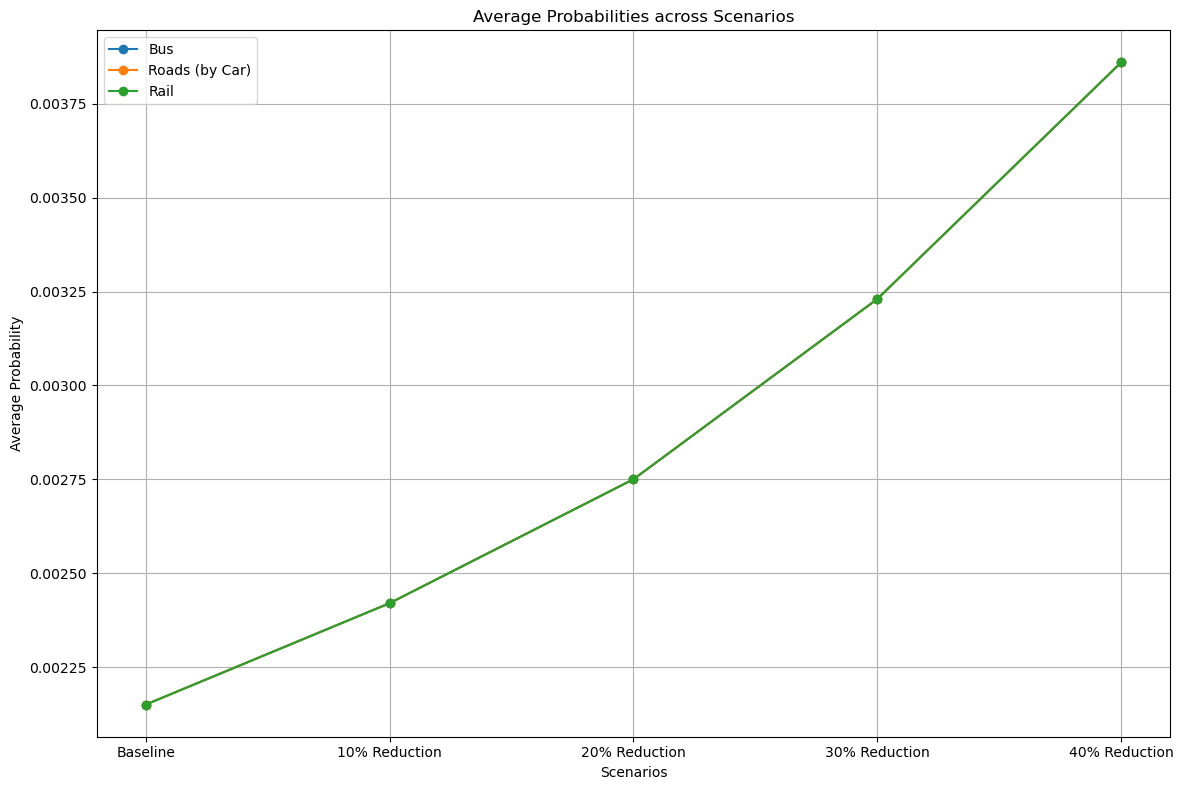

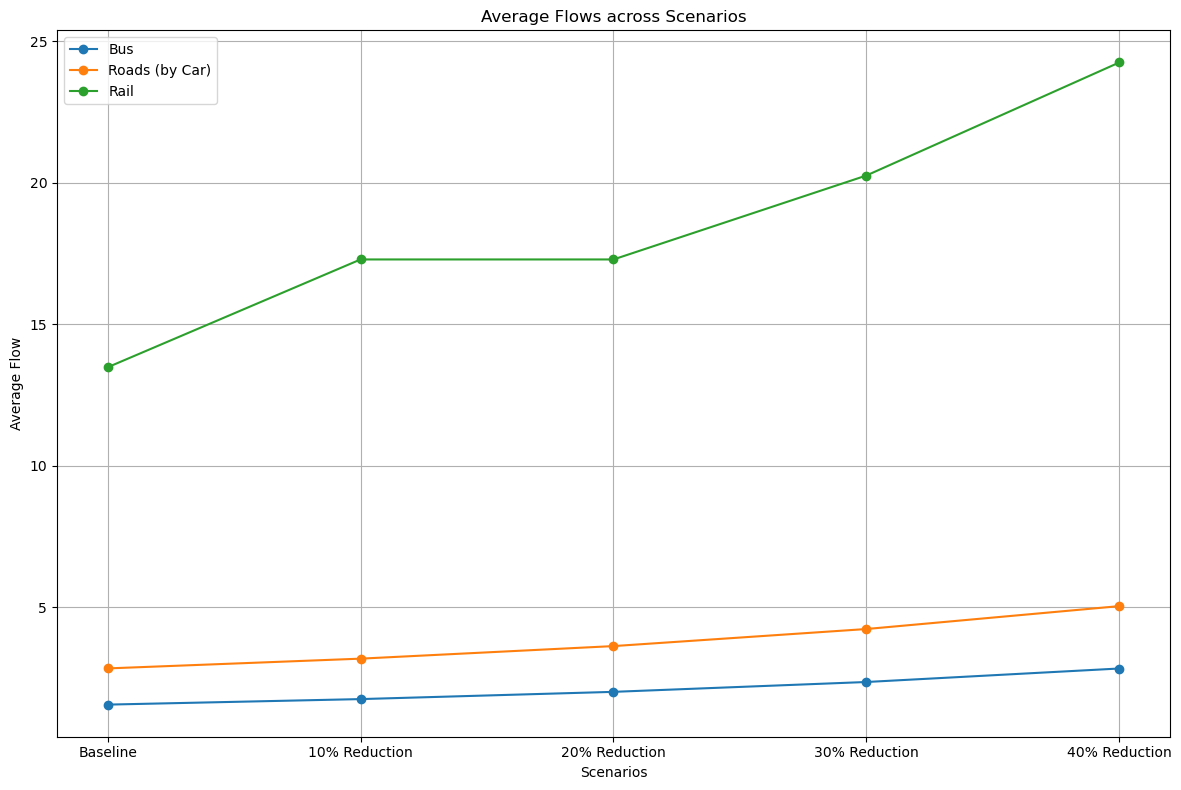

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
scenarios = ["Baseline", "10% Reduction", "20% Reduction", "30% Reduction", "40% Reduction"]
modes = ["Bus", "Roads (by Car)", "Rail"]

# Average Probabilities
avg_probs = {
    "Bus": [0.00215, 0.00242, 0.00275, 0.00323, 0.00386],
    "Roads (by Car)": [0.00215, 0.00242, 0.00275, 0.00323, 0.00386],
    "Rail": [0.00215, 0.00242, 0.00275, 0.00323, 0.00386]
}

# Average Flows
avg_flows = {
    "Bus": [1.554, 1.749, 2.005, 2.353, 2.830],
    "Roads (by Car)": [2.833, 3.178, 3.622, 4.225, 5.034],
    "Rail": [13.473, 17.283, 17.283, 20.249, 24.244]
}

# Plotting Histograms for Average Probabilities
plt.figure(figsize=(12, 8))
for mode in modes:
    plt.plot(scenarios, avg_probs[mode], '-o', label=mode)

plt.title("Average Probabilities across Scenarios")
plt.xlabel("Scenarios")
plt.ylabel("Average Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Average_pro.png")
plt.show()

# Plotting Histograms for Average Flows
plt.figure(figsize=(12, 8))
for mode in modes:
    plt.plot(scenarios, avg_flows[mode], '-o', label=mode)

plt.title("Average Flows across Scenarios")
plt.xlabel("Scenarios")
plt.ylabel("Average Flow")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Average_flow.png")
plt.show()



In [86]:
import matplotlib.pyplot as plt
import pandas as pd

# File paths
bus_files = [
    "data/populationretailRij_bus_2011_10.csv",
    "data/populationretailRij_bus_2011_20.csv",
    "data/populationretailRij_bus_2011_30.csv",
    "data/populationretailRij_bus_2011_40.csv",
    "data/populationretailRij_bus_2011_50.csv"
]

road_files = [
    "data/populationretailRij_roads_2011_10.csv",
    "data/populationretailRij_roads_2011_20.csv",
    "data/populationretailRij_roads_2011_30.csv",
    "data/populationretailRij_roads_2011_40.csv",
    "data/populationretailRij_roads_2011_50.csv"
]

rail_files = [
    "data/populationretailRij_rail_2011_10.csv",
    "data/populationretailRij_rail_2011_20.csv",
    "data/populationretailRij_rail_2011_30.csv",
    "data/populationretailRij_rail_2011_40.csv",
    "data/populationretailRij_rail_2011_50.csv"
]

scenarios = ["Baseline", "10% Reduction", "20% Reduction", "30% Reduction", "40% Reduction"]

# Function to read and plot data
def plot_scenario(bus_file, road_file, rail_file, scenario):
    # Read data
    bus_data = pd.read_csv(bus_file, header=None).values.flatten()
    road_data = pd.read_csv(road_file, header=None).values.flatten()
    rail_data = pd.read_csv(rail_file, header=None).values.flatten()
    
    # Determine custom bin edges
    data_min = min(bus_data.min(), road_data.min(), rail_data.min())
    data_max = max(bus_data.max(), road_data.max(), rail_data.max())
    bin_edges = np.linspace(data_min, data_max, 50)
    
    # Plot data
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    
    axs[0].hist(bus_data, bins=bin_edges, color='blue', alpha=0.7)
    axs[0].set_title(f'Bus Flow for {scenario}')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)
    
    axs[1].hist(road_data, bins=bin_edges, color='green', alpha=0.7)
    axs[1].set_title(f'Roads Flow for {scenario}')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)
    
    axs[2].hist(rail_data, bins=bin_edges, color='red', alpha=0.7)
    axs[2].set_title(f'Rail Flow for {scenario}')
    axs[2].set_xlabel('Flow')
    axs[2].set_ylabel('Frequency')
    axs[2].grid(True)
    
    plt.tight_layout()
    
    # Save the figure with a specific name
    filename = f"{scenario.replace(' ', '_')}_Flow_Distribution.png"
    plt.savefig(filename)
    print(f"Saved: {filename}")
    plt.close(fig)  # Close the figure after saving

# Plot for each scenario
for i, scenario in enumerate(scenarios):
    plot_scenario(bus_files[i], road_files[i], rail_files[i], scenario)


Saved: Baseline_Flow_Distribution.png
Saved: 10%_Reduction_Flow_Distribution.png
Saved: 20%_Reduction_Flow_Distribution.png
Saved: 30%_Reduction_Flow_Distribution.png
Saved: 40%_Reduction_Flow_Distribution.png


In [76]:
df = pd.read_csv("data/populationretailRij_bus_2011_10.csv", header=None)

In [77]:
df

,0,1,2,3,4,5,6,7,8,9,...,456,457,458,459,460,461,462,463,464,465
0,5.253468,1.747000,0.382801,2.179603,0.405186,1.084012,0.698755,3.054518,5.035387,0.900670,...,0.644514,0.336345,3.131313,4.184764,1.407475,2.584875,0.630886,0.924814,0.063993,8.111497
1,0.134388,0.070630,0.004187,0.027546,0.004431,0.013700,0.009503,0.033407,0.053790,0.009850,...,0.042872,52.134703,1.023683,0.045768,0.025494,0.845042,0.022991,0.202877,0.000700,2.651794
2,0.378557,0.198959,0.011793,0.077595,0.012483,0.038591,0.027493,0.094103,0.151522,0.027748,...,0.040984,52.481143,2.961548,0.128924,0.043361,2.444734,0.066513,0.586929,0.001971,7.671724
3,0.141219,0.074221,0.004399,0.028947,0.004657,0.014396,0.010256,0.035105,0.056525,0.010351,...,0.010607,72.099067,1.104793,0.048095,0.016176,0.911998,0.024812,0.218952,0.000735,2.861905
4,0.299315,0.157311,0.009325,0.061352,0.009870,0.030513,0.021738,0.074405,0.119805,0.021939,...,0.019011,58.157504,2.341617,0.101937,0.034285,1.932986,0.052590,0.464069,0.001559,6.065828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,3.155269,1.188987,0.556936,3.940909,0.840153,1.959987,1.179077,6.750470,4.310673,1.681848,...,1.416651,0.202011,1.880689,6.088400,3.093651,1.552494,1.140696,0.555449,0.141424,4.871821
979,1.899509,0.946125,0.510126,3.486305,1.009456,2.007554,1.356461,6.004223,2.595077,1.641244,...,1.038260,0.121613,1.132198,6.484015,2.267330,0.934620,1.196402,0.334387,0.107608,2.932895
980,1.719996,0.610880,0.665765,3.392705,0.982354,1.953656,1.320043,8.196534,2.349829,2.141987,...,1.545240,0.110120,1.025199,6.664750,3.374461,0.846294,1.164281,0.302786,0.166931,2.655722
981,1.623364,0.576559,0.871270,2.473600,1.025210,1.424398,0.962435,9.080327,2.217811,2.803164,...,1.477456,0.103933,0.967601,8.721988,3.226435,0.798747,0.848870,0.285775,0.159609,2.506518


In [79]:
df[0]

0      5.253468
1      0.134388
2      0.378557
3      0.141219
4      0.299315
         ...   
978    3.155269
979    1.899509
980    1.719996
981    1.623364
982    2.377108
Name: 0, Length: 983, dtype: float64

In [82]:
import pandas as pd

# File paths and labels
file_groups = {
    "Bus": bus_files,
    "Roads": road_files,
    "Rail": rail_files
}

# Function to calculate average flow for a file
def calculate_average(file_path):
    data = pd.read_csv(file_path, header=None)
    return data.values.mean()

# Create a markdown table
markdown_table = "| Mode of Transport | Scenario | Average Flow |\n"
markdown_table += "|--------------------|----------|--------------|\n"

for mode, files in file_groups.items():
    for i, file_path in enumerate(files):
        avg_flow = calculate_average(file_path)
        markdown_table += f"| {mode} | {scenarios[i]} | {avg_flow:.3f} |\n"

print(markdown_table)


| Mode of Transport | Scenario | Average Flow |
|--------------------|----------|--------------|
| Bus | Baseline | 1.548 |
| Bus | 10% Reduction | 1.750 |
| Bus | 20% Reduction | 2.006 |
| Bus | 30% Reduction | 2.355 |
| Bus | 40% Reduction | 2.833 |
| Roads | Baseline | 2.832 |
| Roads | 10% Reduction | 3.180 |
| Roads | 20% Reduction | 3.624 |
| Roads | 30% Reduction | 4.227 |
| Roads | 40% Reduction | 5.037 |
| Rail | Baseline | 13.464 |
| Rail | 10% Reduction | 17.276 |
| Rail | 20% Reduction | 17.276 |
| Rail | 30% Reduction | 20.242 |
| Rail | 40% Reduction | 24.236 |



In [88]:
import pandas as pd

# File paths
bus_pro_files = [
    "data/populationretailProbRij_bus_2011_10.csv",
    "data/populationretailProbRij_bus_2011_20.csv",
    "data/populationretailProbRij_bus_2011_30.csv",
    "data/populationretailProbRij_bus_2011_40.csv",
    "data/populationretailProbRij_bus_2011_50.csv"
]

road_pro_files = [
    "data/populationretailProbRij_roads_2011_10.csv",
    "data/populationretailProbRij_roads_2011_20.csv",
    "data/populationretailProbRij_roads_2011_30.csv",
    "data/populationretailProbRij_roads_2011_40.csv",
    "data/populationretailProbRij_roads_2011_50.csv"
]

rail_pro_files = [
    "data/populationretailProbRij_rail_2011_10.csv",
    "data/populationretailProbRij_rail_2011_20.csv",
    "data/populationretailProbRij_rail_2011_30.csv",
    "data/populationretailProbRij_rail_2011_40.csv",
    "data/populationretailProbRij_rail_2011_50.csv"
]

# File paths and labels
file_groups_pro = {
    "Bus": bus_pro_files,
    "Roads": road_pro_files,
    "Rail": rail_pro_files
}

# Function to calculate average flow for a file
def calculate_average(file_path):
    data = pd.read_csv(file_path, header=None)
    return data.values.mean()

# Create a markdown table
markdown_table = "| Mode of Transport | Scenario | Average Flow |\n"
markdown_table += "|--------------------|----------|--------------|\n"

for mode, files in file_groups_pro.items():
    for i, file_path in enumerate(files):
        avg_flow = calculate_average(file_path)
        markdown_table += f"| {mode} | {scenarios[i]} | {avg_flow:.6f} |\n"

print(markdown_table)

| Mode of Transport | Scenario | Average Flow |
|--------------------|----------|--------------|
| Bus | Baseline | 0.002146 |
| Bus | 10% Reduction | 0.002415 |
| Bus | 20% Reduction | 0.002755 |
| Bus | 30% Reduction | 0.003226 |
| Bus | 40% Reduction | 0.003861 |
| Roads | Baseline | 0.002146 |
| Roads | 10% Reduction | 0.002415 |
| Roads | 20% Reduction | 0.002755 |
| Roads | 30% Reduction | 0.003226 |
| Roads | 40% Reduction | 0.003861 |
| Rail | Baseline | 0.002146 |
| Rail | 10% Reduction | 0.002415 |
| Rail | 20% Reduction | 0.002755 |
| Rail | 30% Reduction | 0.003226 |
| Rail | 40% Reduction | 0.003861 |



In [89]:
import matplotlib.pyplot as plt
import pandas as pd




scenarios = ["Baseline", "10% Reduction", "20% Reduction", "30% Reduction", "40% Reduction"]

# Function to read and plot data
def plot_scenario(bus_pro_file, road_pro_file, rail_pro_file, scenario):
    # Read data
    bus_data = pd.read_csv(bus_pro_file, header=None).values.flatten()
    road_data = pd.read_csv(road_pro_file, header=None).values.flatten()
    rail_data = pd.read_csv(rail_pro_file, header=None).values.flatten()
    
    # Determine custom bin edges
    data_min = min(bus_data.min(), road_data.min(), rail_data.min())
    data_max = max(bus_data.max(), road_data.max(), rail_data.max())
    bin_edges = np.linspace(data_min, data_max, 50)
    
    # Plot data
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    
    axs[0].hist(bus_data, bins=bin_edges, color='blue', alpha=0.7)
    axs[0].set_title(f'Bus Probability for {scenario}')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True)
    
    axs[1].hist(road_data, bins=bin_edges, color='green', alpha=0.7)
    axs[1].set_title(f'Roads Probability for {scenario}')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)
    
    axs[2].hist(rail_data, bins=bin_edges, color='red', alpha=0.7)
    axs[2].set_title(f'Rail Probability for {scenario}')
    axs[2].set_xlabel('Probability')
    axs[2].set_ylabel('Frequency')
    axs[2].grid(True)
    
    plt.tight_layout()
    
    # Save the figure with a specific name
    filename = f"{scenario.replace(' ', '_')}_Pro_Distribution.png"
    plt.savefig(filename)
    print(f"Saved: {filename}")
    plt.close(fig)  # Close the figure after saving

# Plot for each scenario
for i, scenario in enumerate(scenarios):
    plot_scenario(bus_pro_files[i], road_pro_files[i], rail_pro_files[i], scenario)

Saved: Baseline_Pro_Distribution.png
Saved: 10%_Reduction_Pro_Distribution.png
Saved: 20%_Reduction_Pro_Distribution.png
Saved: 30%_Reduction_Pro_Distribution.png
Saved: 40%_Reduction_Pro_Distribution.png
